In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import linprog
import scipy.optimize as opt
import scipy
from scipy.stats import norm as scipy_norm
%matplotlib inline
import cvxpy as cp
from cvxpy.atoms.norm import norm
from cvxpy.atoms.affine.sum import sum

In [25]:
x = np.array([0, 4, 8, 12, 16, 20, 24])
y = np.array([4, 5, 4, 6, 5, 7, 4])
c = np.array([3, 2, 2, 1, 2])
y_p = cp.Variable(5)
objective = cp.Minimize((y_p[1] - y_p[0])**2 +
                        (y_p[2] - y_p[1])**2 + 
                        (y_p[3] - y_p[2])**2 + 
                        (y_p[4] - y_p[3])**2 +
                        (y_p[0] - y[0])**2 +
                        (y_p[4] - y[6])**2)

constraints = [y_p >= y[1:-1] - c/2,
               y_p <= y[1:-1] + c/2]
prob = cp.Problem(objective, constraints)
print(objective.is_dcp())
print(prob.get_problem_data('ECOS'))

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve(verbose=True)
print(result)
# The optimal value for x is stored in `x.value`.
print(y_p.value)

True
({'c': array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]), 'offset': array([0.]), 'dims': <cvxpy.reductions.solvers.conic_solvers.conic_solver.ConeDims object at 0x7f34e4b3ff28>, 'A': None, 'b': None, 'G': <28x11 sparse matrix of type '<class 'numpy.float64'>'
	with 32 stored elements in Compressed Sparse Column format>, 'h': array([-3.5, -3. , -5. , -4.5, -6. ,  6.5,  5. ,  7. ,  5.5,  8. ,  1. ,
       -1. ,  0. ,  1. , -1. ,  0. ,  1. , -1. ,  0. ,  1. , -1. ,  0. ,
        1. , -1. , -8. ,  1. , -1. , -8. ])}, <cvxpy.reductions.solvers.solving_chain.SolvingChain object at 0x7f34e4bc5278>, [<cvxpy.reductions.inverse_data.InverseData object at 0x7f34e4ca4e80>, (), <cvxpy.reductions.inverse_data.InverseData object at 0x7f34e4c14588>, {'var_id': 494, 'offset': 0.0, 'eq_constr': [], 'other_constr': [NonPos(Expression(AFFINE, UNKNOWN, (5,))), NonPos(Expression(AFFINE, UNKNOWN, (5,))), SOC(Expression(AFFINE, UNKNOWN, (1,))), SOC(Expression(AFFINE, UNKNOWN, (1,))), SOC(Expression(AFF

In [140]:
r_hat = np.array([0.12, 0.10, 0.07, 0.03])
sigma = np.array([[0.0064, 0.0008, -0.0011, 0],
        [0.0008, 0.0025, 0, 0],
        [-0.0011, 0, 0.0004, 0],
        [0, 0, 0, 0]])
sigma_sqrt = scipy.linalg.sqrtm(sigma)
epsilon = lambda e: scipy_norm.ppf(e)

def solve_this_scipy(e):
    res = scipy.optimize.minimize(lambda x: -(np.dot(r_hat, x)), method='SLSQP', 
                                    x0 = [0.25, 0.25, 0.25, 0.25],
                                    bounds = [(0.05, 0.4), (0.05, 0.4), (0.05, 0.4), (0.05, 0.2)],
                                    constraints = [{
        'type': 'ineq',
        'fun': lambda x: -(np.linalg.norm(np.dot(sigma_sqrt, x))*epsilon(10e-4) - (-0.03) + np.dot(r_hat, x))
    },
    {
        'type': 'eq',
        'fun': lambda x: np.sum(x) - 1
    }])
    return (e, res.fun, res.x)
solve_this_scipy(10e-3)

(0.01,
 -0.09589768646831187,
 array([0.4       , 0.4       , 0.05      , 0.14658955]))

In [143]:
import cvxpy as cp
from cvxpy.atoms.norm import norm
from cvxpy.atoms.affine.sum import sum

def solve_this(e):
    x = cp.Variable(4)
    objective = cp.Maximize(r_hat @ x)
    constraints = [x >= 0.05,
                   x <= 0.4,
                   x[3] >= 0.2,
                   norm(sigma_sqrt @ x) <= (1/epsilon(e))*(-0.03 - (r_hat @ x)),
                   sum(x) == 1]
    prob = cp.Problem(objective, constraints)

    # The optimal objective value is returned by `prob.solve()`.
    result = prob.solve()
    #print(result)
    # The optimal value for x is stored in `x.value`.
    #print(x.value)
    return (e, result, x.value)
solve_this(10e-4)

In [144]:
sols = [solve_this(e) for e in np.logspace(-6, 0, 100)]

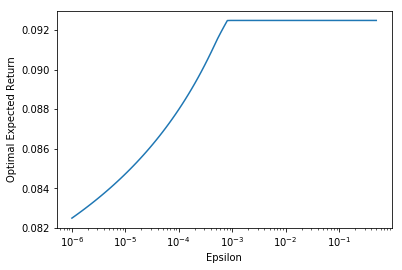

In [145]:
sols = list(filter(lambda x: x[1] != float('-inf'), sols))
plt.semilogx([x[0] for x in sols], [x[1] for x in sols])
plt.xlabel('Epsilon')
plt.ylabel('Optimal Expected Return')
plt.savefig('problem4_sweep_epsilon.png', dpi=300)

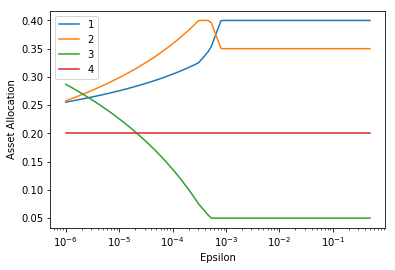

In [146]:
plt.semilogx([x[0] for x in sols], [x[2][0] for x in sols])
plt.semilogx([x[0] for x in sols], [x[2][1] for x in sols])
plt.semilogx([x[0] for x in sols], [x[2][2] for x in sols])
plt.semilogx([x[0] for x in sols], [x[2][3] for x in sols])
plt.legend(['1', '2', '3', '4'])
plt.xlabel('Epsilon')
plt.ylabel('Asset Allocation')
plt.savefig('problem4_area_plot.png', dpi=300)

[[0.17872895 0.07487718 0.06877107 0.03      ]
 [0.15529328 0.05512308 0.07836715 0.03      ]
 [0.13925772 0.2196366  0.07056561 0.03      ]
 ...
 [0.15457482 0.12632627 0.05629405 0.03      ]
 [0.15422106 0.09453467 0.05995214 0.03      ]
 [0.10319449 0.0791406  0.06299822 0.03      ]]


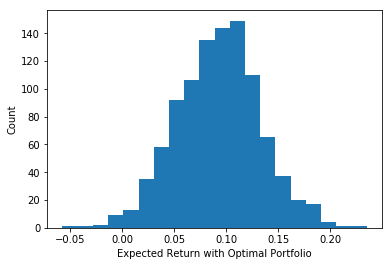

In [157]:
x = solve_this(10e-4)[2]
r_samps = np.random.multivariate_normal(r_hat, sigma, 1000)
plt.hist(np.dot(r_samps, x), 20)
plt.xlabel('Expected Return with Optimal Portfolio')
plt.ylabel('Count')
plt.savefig('problem4_monte_carlo.png', dpi=300)
print(r_samps)

In [166]:
np.mean(np.dot(r_samps, x))

len([x for x in np.dot(r_samps, x) if x < 0])
13/1000

0.013